# **Online Retail Transactions - ETL**

## Objectives

* This notebook prepare online retail transaction data to perfrom analysis on customer behavior, identify popular products, and optimize business strategies. 

## Inputs

*  [Online Retail Transactions Dataset from Kaggle](https://www.kaggle.com/datasets/abhishekrp1517/online-retail-transactions-dataset) 

## Outputs

* Cleaned and transformed data



We want to Load the data from the original data set reside within data directory

In [1]:
import os
import numpy as np
import pandas as pd

# Data directory paths
data_path = os.path.join("..", "data")

df_original = pd.read_csv(os.path.join(data_path, "online_retail.csv"))
print(f"Original dataset shape: {df_original.shape}")

Original dataset shape: (541909, 8)


We need to have the initial look at the data set in nhigh level

In [5]:
# Quick Look 
print("=== Quick look at five rows ===")
with pd.option_context('display.max_columns', None):
    print(df_original.head())

# How many rows and columns
print("=== How many rows and columns ===")
print(df_original.shape)

# What are the column name
print("=== What are the column name ===")
print(df_original.columns)

# Data counts 
print("=== Data counts ===")
print(df_original.info())

# NA counts
print("=== Is there any nulls ===")
print(df_original.isna().sum())

# Duplicate counts
print("=== Is there any duplicated rows ===")
print(df_original.duplicated().sum())

# Basic stats for numeric columns
print("=== Basic stats for numeric columns ===")
print(df_original.describe())

=== Quick look at five rows ===
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01/12/2010 08:26       2.55       17850  United Kingdom  
1  01/12/2010 08:26       3.39       17850  United Kingdom  
2  01/12/2010 08:26       2.75       17850  United Kingdom  
3  01/12/2010 08:26       3.39       17850  United Kingdom  
4  01/12/2010 08:26       3.39       17850  United Kingdom  
=== How many rows and columns ===
(541909, 8)
=== What are the column name ===
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPri

We need to furhter analyse the data set as the Initial look shows that
*  There are minus values in quantity and unit price
*  There are extreme outliers 

In [6]:
# Explore negative quantities and prices

print("\nNumber of invoices with Quantity and UnitPrice > 0 :")
dfnqu = df_original[(df_original['Quantity'] < 0) | (df_original['UnitPrice'] < 0)]
with pd.option_context('display.max_columns', None, 'display.width', 1000):
    print(dfnqu.head())
print(dfnqu['InvoiceNo'].nunique())
print("\nShape of the Data Set:")
print(dfnqu.shape)

# Explore Invoices with the code C
print("\nNumber of negative invoices:")
dfc = df_original[df_original['InvoiceNo'].astype(str).str.startswith('C')]
with pd.option_context('display.max_columns', None, 'display.width', 1000):
    print(dfc.head())
print(dfc['InvoiceNo'].nunique())

print("\nShape of the Data Set:")
print(dfc.shape)


Number of invoices with Quantity and UnitPrice > 0 :
    InvoiceNo StockCode                       Description  Quantity       InvoiceDate  UnitPrice  CustomerID         Country
141   C536379         D                          Discount        -1  01/12/2010 09:41      27.50       14527  United Kingdom
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1  01/12/2010 09:49       4.65       15311  United Kingdom
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12  01/12/2010 10:24       1.65       17548  United Kingdom
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24  01/12/2010 10:24       0.29       17548  United Kingdom
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24  01/12/2010 10:24       0.29       17548  United Kingdom
5174

Shape of the Data Set:
(10626, 8)

Number of negative invoices:
    InvoiceNo StockCode                       Description  Quantity       InvoiceDate  UnitPrice  CustomerID         Country
1

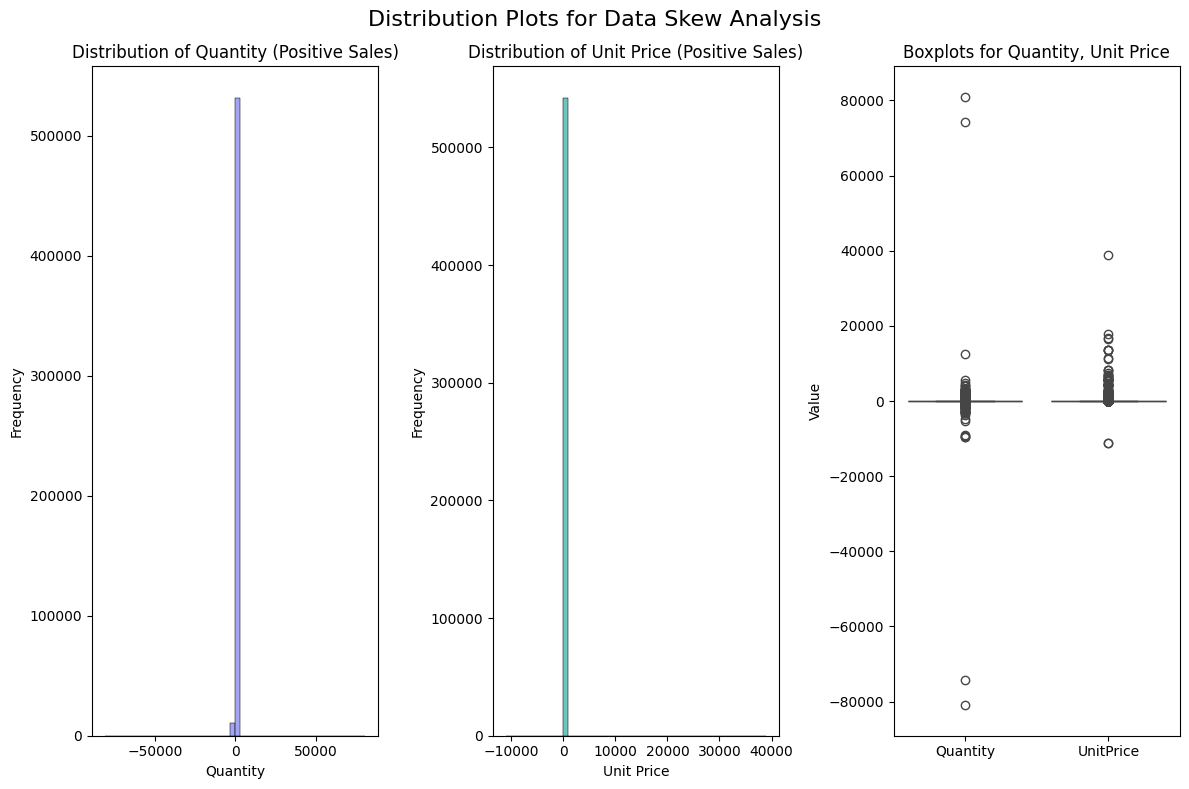

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create distribution plots to identify data skews
figsize = (12, 8)
theme_colors = ['#8686F2', '#38B3AA', '#E85573', '#E59F55', '#E67642', '#5778D3']

# Subplots for distributions
fig, axes = plt.subplots(1, 3, figsize=figsize)
fig.suptitle('Distribution Plots for Data Skew Analysis', fontsize=16)

# Quantity distribution (positive only for sales)
sns.histplot(df_original['Quantity'], bins=50, ax=axes[0], color=theme_colors[0])
axes[0].set_title('Distribution of Quantity (Positive Sales)')
axes[0].set_xlabel('Quantity')
axes[0].set_ylabel('Frequency')

# UnitPrice distribution (positive)
sns.histplot(df_original['UnitPrice'], bins=50, ax=axes[1], color=theme_colors[1])
axes[1].set_title('Distribution of Unit Price (Positive Sales)')
axes[1].set_xlabel('Unit Price')
axes[1].set_ylabel('Frequency')


# Boxplot for Quantity, UnitPrice, Revenue
sns.boxplot(data=df_original[['Quantity', 'UnitPrice']], ax=axes[2], palette=theme_colors[:2])
axes[2].set_title('Boxplots for Quantity, Unit Price')
axes[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [8]:
#Simple analysis to understand outlier causes
print("=== OUTLIER INVESTIGATION ===")

# Check the most extreme high values - Quntities
print("HIGHEST QUANTITIES:")
high_qty = df_original.nlargest(2, 'Quantity')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice']]
print(high_qty)
print("\n")

# Check the most extreme low values - Quntities
print("LOWEST QUANTITIES:")
low_qty = df_original.nsmallest(2, 'Quantity')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice']]
print(low_qty)
print("\n")

print("HIGHEST UNIT PRICES:")
high_price = df_original.nlargest(5, 'UnitPrice')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice']]
print(high_price)
print("\n")


=== OUTLIER INVESTIGATION ===
HIGHEST QUANTITIES:
       InvoiceNo StockCode                     Description  Quantity  \
540421    581483     23843     PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   

        UnitPrice  
540421       2.08  
61619        1.04  


LOWEST QUANTITIES:
       InvoiceNo StockCode                     Description  Quantity  \
540422   C581484     23843     PAPER CRAFT , LITTLE BIRDIE    -80995   
61624    C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   

        UnitPrice  
540422       2.08  
61624        1.04  


HIGHEST UNIT PRICES:
       InvoiceNo  StockCode Description  Quantity  UnitPrice
222681   C556445          M      Manual        -1   38970.00
524602   C580605  AMAZONFEE  AMAZON FEE        -1   17836.46
43702    C540117  AMAZONFEE  AMAZON FEE        -1   16888.02
43703    C540118  AMAZONFEE  AMAZON FEE        -1   16453.71
15016    C537630  AMAZONFEE  AMAZON FEE        

We need to transform and clean the data set
* Remove to duplicated rows 
* Remove Adjustments 
* Handle extreme outliers in quantity: Above outlier analysis revealed interestig piece of information. There are matching sales invoices for the return invices with same StockCode, UnitPrice and quantity. So, we can remove the sales invoice and the return invoice to remove extreme outliers
* Fill missing values in Description with 'Unknown' 
* Add new features Revenue / Date of Invoice and Customer Segments
* Seperate data set into Sales and Returns with minus values in quantity along

Remove to duplicated rows

In [9]:
print("=== CLEANING DATA ===")
# Remove all duplicate rows
df_clean = df_original.drop_duplicates().reset_index(drop=True)

# How many rows and columns after removing duplicates
print("=== How many rows and columns after removing duplicates ===")
print(f"Original Data Set: {df_original.shape}")
print(f"After removing duplicates: {df_clean.shape}")

=== CLEANING DATA ===
=== How many rows and columns after removing duplicates ===
Original Data Set: (541909, 8)
After removing duplicates: (536641, 8)


Remove Adjustments

In [ ]:
# View Adjustments (wheere negatve unit price presents)
df_adjust=df_clean[df_clean['InvoiceNo'].astype(str).str.startswith('A', na=False)]
print(f"Shape after removing adjustments: {df_adjust.shape}")
# Remove adjustments from the main dataframe
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('A', na=False)]
print(f"Shape after removing adjustments: {df_clean.shape}")

Shape after removing adjustments: (3, 8)
Shape after removing adjustments: (536638, 8)


Handle extreme outliers in quantity: Above outlier analysis revealed interestig piece of information. There are matching sales invoices for the return invices with same StockCode, UnitPrice and quantity. So, we can remove the sales invoice and the return invoice to remove extreme outliers

In [10]:
#Handle extreme outliers in quantity
# Remove the rows with INVOICENOs 581483 , 541431, C581484,C541433
extreme_outliers = ['581483', '541431', 'C581484', 'C541433']
df_clean = df_clean[~df_clean['InvoiceNo'].isin(extreme_outliers)]
print(f"Removed invoices: {extreme_outliers}")
print(f"Remaining rows: {len(df_clean)}")

Removed invoices: ['581483', '541431', 'C581484', 'C541433']
Remaining rows: 536637


Check the distribution and boxplots after removing extreme outliers 

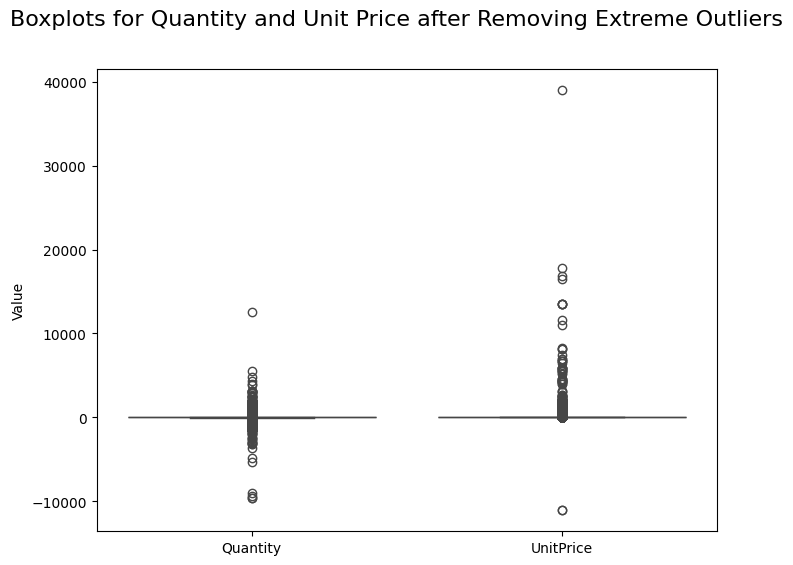

In [11]:
# Check the distribution and boxplots after removing extreme outliers
# Boxplot for Quantity, UnitPrice, Revenue
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Boxplots for Quantity and Unit Price after Removing Extreme Outliers', fontsize=16)   
sns.boxplot(data=df_clean[['Quantity', 'UnitPrice']], palette=theme_colors[:2])
ax.set_ylabel('Value')
plt.show()

Fill missing values in Description with 'Unknown' 

In [12]:
# Fill missing values in Description with 'Unknown' 
df_clean['Description'] = df_clean['Description'].fillna('Unknown')

print("=== Original Dataset ===")
print(df_original.isna().sum())
print("=== After addressing missing values ===")
print(df_clean.isna().sum())


=== Original Dataset ===
InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64
=== After addressing missing values ===
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


# TRANSFORMING DATA
We need to introduce new features to support analysis   

In [14]:
#Add new features Revenue / Date of Invoice and Customer Segments
df_transform = df_clean.copy()
df_transform['InvoiceDate'] = pd.to_datetime(df_transform['InvoiceDate'], dayfirst=True) 
# Create revenue and derived features
df_transform['Revenue'] = df_transform['Quantity'] * df_transform['UnitPrice']
df_transform['Year'] = df_transform['InvoiceDate'].dt.year
df_transform['Month'] = df_transform['InvoiceDate'].dt.month
df_transform['Day'] = df_transform['InvoiceDate'].dt.day
df_transform['Weekday'] = df_transform['InvoiceDate'].dt.day_name()
df_transform['Hour'] = df_transform['InvoiceDate'].dt.hour

We need to have seperate data sets for Sales and Returns for better analysis

In [15]:
# Create Seperate data set into Sales and Returns
df_sales = df_transform[df_clean['Quantity'] >= 0]
df_returns = df_transform[(df_clean['Quantity'] < 0) & (df_clean['UnitPrice'] >0)]
print(f"Transformed dataset shape: {df_transform.shape}")
print(f"Sales dataset shape: {df_sales.shape}")
print(f"Return dataset shape: {df_returns.shape}")

Transformed dataset shape: (536637, 14)
Sales dataset shape: (526052, 14)
Return dataset shape: (9249, 14)


# LOADING DATA
We need to load the data into CSVs to use by analysts 

In [16]:
print("=== LOADING DATA ===")

# Data directory paths
data_path = os.path.join("..", "data")

df_original = pd.read_csv(os.path.join(data_path, "online_retail.csv"))

df_transform.to_csv(os.path.join(data_path, "online_retail_clean.csv"), index=False)
df_sales.to_csv(os.path.join(data_path, "online_retail_sales.csv"), index=False)
df_returns.to_csv(os.path.join(data_path, "online_retail_returns.csv"), index=False)
print(f"Data saved to {os.path.join(data_path,'_*.csv')} files")

=== LOADING DATA ===
Data saved to ..\data\_*.csv files
